In [1]:
!pip install recommenders cornac==2.3.0 optuna==4.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 12.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.4/25.4 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.3/355.3 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 105.9 MB/s

In [2]:
!add-apt-repository ppa:ubuntu-toolchain-r/test
!apt-get update
!apt-get install --only-upgrade libstdc++6

PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntu-toolchain-r/test/ubuntu/ jammy main'
Description:
Toolchain test builds; see https://wiki.ubuntu.com/ToolChain

More info: https://launchpad.net/~ubuntu-toolchain-r/+archive/ubuntu/test
Adding repository.
Press [ENTER] to continue or Ctrl-c to cancel.
Adding deb entry to /etc/apt/sources.list.d/ubuntu-toolchain-r-ubuntu-test-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntu-toolchain-r-ubuntu-test-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntu-toolchain-r-ubuntu-test.gpg with fingerprint C8EC952E2A0E1FBDC5090F6A2C277A0A352154E5
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,384 kB]
Get:4 http://secur

In [1]:
import pandas as pd
import sys
import cornac
import itertools
import optuna

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_random_split, python_chrono_split
from recommenders.evaluation.python_evaluation import (
    rmse,
    mae,
    rsquared,
    exp_var,
    map_at_k,
    ndcg_at_k,
    precision_at_k,
    recall_at_k,
    get_top_k_items,
)

from recommenders.utils.notebook_utils import store_metadata
from recommenders.models.cornac.cornac_utils import predict_ranking
from cornac.eval_methods import NextItemEvaluation

from collections import OrderedDict, defaultdict
import numpy as np
from tqdm.notebook import tqdm

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Optuna Version: {optuna.__version__}")

System version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Cornac version: 2.3.0
Optuna Version: 4.2.1


In [6]:
DATA_PATH = '/content/drive/MyDrive/Final Project/Codes/animelist-goodbooks-recommendation/goodbooks-10k/data_sample_split/'

In [7]:
train_data = pd.read_csv(f'{DATA_PATH}/data_train.tsv', sep='\t')
valid_data = pd.read_csv(f'{DATA_PATH}/data_valid.tsv', sep='\t')

In [9]:
# top k items to recommend
TOP_K = 20
NUM_EPOCHS = 20
SEED=100

In [10]:
train_data['time'] = pd.to_datetime(train_data["time"], utc=True).astype(int) // 10**9
valid_data['time'] = pd.to_datetime(valid_data["time"], utc=True).astype(int) // 10**9

In [11]:
def ranking_eval(
    model,
    train_set,
    test_set,
    exclude_unknowns=True,
    mode="last",
    verbose=False,
):

    rankings = []
    scores = []
    user_sessions = defaultdict(list)
    session_ids = []
    for [sid], [mapped_ids], [session_items] in tqdm(
        test_set.si_iter(batch_size=1, shuffle=False),
        total=len(test_set.sessions)):

        if len(session_items) < 2:  # exclude all session with size smaller than 2
            continue
        user_idx = test_set.uir_tuple[0][mapped_ids[0]]
        session_ids.append(sid)

        start_pos = 1 if mode == "next" else len(session_items) - 1
        for test_pos in range(start_pos, len(session_items), 1):
            test_pos_items = session_items[test_pos]

            # binary mask for ground-truth positive items
            u_gt_pos_mask = np.zeros(test_set.num_items, dtype="int")
            u_gt_pos_mask[test_pos_items] = 1

            # binary mask for ground-truth negative items, removing all positive items
            u_gt_neg_mask = np.ones(test_set.num_items, dtype="int")
            u_gt_neg_mask[test_pos_items] = 0

            # filter items being considered for evaluation
            if exclude_unknowns:
                u_gt_pos_mask = u_gt_pos_mask[: train_set.num_items]
                u_gt_neg_mask = u_gt_neg_mask[: train_set.num_items]

            u_gt_pos_items = np.nonzero(u_gt_pos_mask)[0]
            u_gt_neg_items = np.nonzero(u_gt_neg_mask)[0]
            item_indices = np.nonzero(u_gt_pos_mask + u_gt_neg_mask)[0]


            item_rank, item_scores = model.rank(
                user_idx,
                item_indices,
                history_items=session_items[:test_pos],
                history_mapped_ids=mapped_ids[:test_pos],
                sessions=test_set.sessions,
                session_indices=test_set.session_indices,
                extra_data=test_set.extra_data,
            )
            item_scores = item_scores[item_rank]
            item_rank = [key for value in item_rank for key, val in train_set.iid_map.items() if val == value]

            rankings.append(item_rank)
            scores.append(item_scores)

    return rankings, scores

In [16]:
class Objective(object):
    def __init__(self, train_data, valid_data):
        next_item_eval = NextItemEvaluation.from_splits(
            train_data=list(train_data[['user_id', 'book_id', 'time']].itertuples(index=False)),
            test_data=list(valid_data[['user_id', 'book_id', 'time']].itertuples(index=False)),
            exclude_unknowns=True,
            verbose=False,
            fmt="SIT",
        )
        self.train_data = train_data
        self.valid_data = valid_data
        self.train_set = next_item_eval.train_set
        self.valid_set = next_item_eval.test_set

    def __call__(self, trial):

        layers = trial.suggest_int("layers", 100, 500, step=50)
        learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
        dropout_p_embed = trial.suggest_float("dropout_p_embed", 0, 0.5)
        dropout_p_hidden = trial.suggest_float("dropout_p_hidden", 0, 0.5)
        loss = trial.suggest_categorical("loss", ["cross-entropy", "bpr-max"])
        gru = cornac.models.GRU4Rec(
            layers=[layers],
            loss=loss,
            learning_rate=learning_rate,
            dropout_p_embed=dropout_p_embed,
            dropout_p_hidden=dropout_p_hidden,
            batch_size=128,
            n_epochs=NUM_EPOCHS,
            device="cuda",
            verbose=True,
            seed=SEED,
        )
        gru.fit(self.train_set)
        gru.transform(self.valid_set)

        gru_ranking, gru_scores = ranking_eval(
          gru,
          self.train_set,
          self.valid_set,
          exclude_unknowns=True,
          mode="last",
          verbose=False,
        )
        users = []
        item = list(gru.train_set.iid_map.keys())
        for uid, user_idx in gru.train_set.sid_map.items():
            user = [uid] * len(item)
            users.extend(user)

        flattened_ranking = list(itertools.chain(*gru_ranking))
        flattened_score= list(itertools.chain(*gru_scores))

        df_gru_predictions = pd.DataFrame({'user_id':users, 'book_id':flattened_ranking, 'prediction': flattened_score})

        ndcg_score = ndcg_at_k(self.valid_data, df_gru_predictions, col_user="user_id", col_item="book_id", col_rating='rating', k=10)

        return ndcg_score

In [18]:
objective = Objective(train_data, valid_data)
study_name = "goodbooks-gru"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

study = optuna.create_study(direction="maximize", study_name=study_name, storage=storage_name)
study.optimize(objective, n_trials=20, n_jobs=5)

[I 2025-04-18 00:35:46,801] A new study created in RDB with name: goodbooks-gru


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-18 02:47:31,516] Trial 0 finished with value: 0.22813142516057464 and parameters: {'layers': 250, 'learning_rate': 0.004905505613627818, 'dropout_p_embed': 0.1975716768182706, 'dropout_p_hidden': 0.40715416793750314, 'loss': 'bpr-max'}. Best is trial 0 with value: 0.22813142516057464.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-18 03:07:05,283] Trial 1 finished with value: 0.11193959208124216 and parameters: {'layers': 350, 'learning_rate': 0.027265880878690314, 'dropout_p_embed': 0.03851442233304736, 'dropout_p_hidden': 0.07152141847564364, 'loss': 'bpr-max'}. Best is trial 0 with value: 0.22813142516057464.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-18 03:40:26,857] Trial 3 finished with value: 0.2640129268793489 and parameters: {'layers': 150, 'learning_rate': 0.009181007532589557, 'dropout_p_embed': 0.025684449992426417, 'dropout_p_hidden': 0.4707059038239166, 'loss': 'cross-entropy'}. Best is trial 3 with value: 0.2640129268793489.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-18 03:45:11,777] Trial 2 finished with value: 0.23855528808408438 and parameters: {'layers': 100, 'learning_rate': 0.0034243131197067207, 'dropout_p_embed': 0.4566937017948674, 'dropout_p_hidden': 0.4172489348950422, 'loss': 'bpr-max'}. Best is trial 3 with value: 0.2640129268793489.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-18 04:05:50,551] Trial 4 finished with value: 0.2178819923850913 and parameters: {'layers': 350, 'learning_rate': 0.007981822093693478, 'dropout_p_embed': 0.05708483324050789, 'dropout_p_hidden': 0.26155725451981743, 'loss': 'cross-entropy'}. Best is trial 3 with value: 0.2640129268793489.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-18 04:28:40,781] Trial 5 finished with value: 0.19363239626677087 and parameters: {'layers': 100, 'learning_rate': 0.025330796018647503, 'dropout_p_embed': 0.009256561634136129, 'dropout_p_hidden': 0.0010274651392064293, 'loss': 'cross-entropy'}. Best is trial 3 with value: 0.2640129268793489.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-18 04:50:37,491] Trial 6 finished with value: 0.21040360640917846 and parameters: {'layers': 500, 'learning_rate': 0.003470982750604493, 'dropout_p_embed': 0.18182919386390078, 'dropout_p_hidden': 0.49149808142671547, 'loss': 'bpr-max'}. Best is trial 3 with value: 0.2640129268793489.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-18 05:10:14,632] Trial 8 finished with value: 0.22435591037449368 and parameters: {'layers': 500, 'learning_rate': 0.0015619004582008494, 'dropout_p_embed': 0.14707659875714546, 'dropout_p_hidden': 0.045422949791118994, 'loss': 'cross-entropy'}. Best is trial 3 with value: 0.2640129268793489.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-18 05:30:43,983] Trial 7 finished with value: 0.13133325266316456 and parameters: {'layers': 500, 'learning_rate': 0.04066804298238944, 'dropout_p_embed': 0.09136958320037536, 'dropout_p_hidden': 0.3783363260129422, 'loss': 'bpr-max'}. Best is trial 3 with value: 0.2640129268793489.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-18 05:53:32,373] Trial 10 finished with value: 0.2484630341190932 and parameters: {'layers': 200, 'learning_rate': 0.007186846876070532, 'dropout_p_embed': 0.394782012764503, 'dropout_p_hidden': 0.481984494283705, 'loss': 'bpr-max'}. Best is trial 3 with value: 0.2640129268793489.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-18 06:30:15,607] Trial 11 finished with value: 0.24661742325701808 and parameters: {'layers': 350, 'learning_rate': 0.00449574238748221, 'dropout_p_embed': 0.4203133266609957, 'dropout_p_hidden': 0.169248298222216, 'loss': 'cross-entropy'}. Best is trial 3 with value: 0.2640129268793489.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-18 06:32:56,865] Trial 9 finished with value: 0.20551191688942894 and parameters: {'layers': 300, 'learning_rate': 0.002282171781039649, 'dropout_p_embed': 0.01271246940418913, 'dropout_p_hidden': 0.09831416333104137, 'loss': 'bpr-max'}. Best is trial 3 with value: 0.2640129268793489.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-18 06:54:41,170] Trial 12 finished with value: 0.1980013008064556 and parameters: {'layers': 400, 'learning_rate': 0.0028090453293683087, 'dropout_p_embed': 0.4179523398699085, 'dropout_p_hidden': 0.007370532102105587, 'loss': 'bpr-max'}. Best is trial 3 with value: 0.2640129268793489.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-18 07:15:15,028] Trial 13 finished with value: 0.19962610430495584 and parameters: {'layers': 200, 'learning_rate': 0.02143922343567978, 'dropout_p_embed': 0.22001366023962649, 'dropout_p_hidden': 0.28608635339182026, 'loss': 'cross-entropy'}. Best is trial 3 with value: 0.2640129268793489.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-18 07:35:37,490] Trial 14 finished with value: 0.22498592023096511 and parameters: {'layers': 200, 'learning_rate': 0.01551708800965695, 'dropout_p_embed': 0.31502968244569857, 'dropout_p_hidden': 0.24687068490626649, 'loss': 'cross-entropy'}. Best is trial 3 with value: 0.2640129268793489.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-18 07:57:09,142] Trial 15 finished with value: 0.25830011924447455 and parameters: {'layers': 200, 'learning_rate': 0.01413037757214035, 'dropout_p_embed': 0.34661723991474935, 'dropout_p_hidden': 0.4964552949697958, 'loss': 'cross-entropy'}. Best is trial 3 with value: 0.2640129268793489.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-18 08:24:41,331] Trial 16 finished with value: 0.25863985435925696 and parameters: {'layers': 200, 'learning_rate': 0.013750313839035803, 'dropout_p_embed': 0.3253112622470538, 'dropout_p_hidden': 0.49518684178730105, 'loss': 'cross-entropy'}. Best is trial 3 with value: 0.2640129268793489.
[I 2025-04-18 08:36:25,242] Trial 17 finished with value: 0.1636675413352154 and parameters: {'layers': 200, 'learning_rate': 0.0991942472932749, 'dropout_p_embed': 0.3255049164158391, 'dropout_p_hidden': 0.310611545169606, 'loss': 'cross-entropy'}. Best is trial 3 with value: 0.2640129268793489.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-18 08:58:20,020] Trial 18 finished with value: 0.2606483360764552 and parameters: {'layers': 200, 'learning_rate': 0.01310873326077331, 'dropout_p_embed': 0.30364240094366574, 'dropout_p_hidden': 0.4936524507114305, 'loss': 'cross-entropy'}. Best is trial 3 with value: 0.2640129268793489.
[I 2025-04-18 09:13:19,552] Trial 19 finished with value: 0.2095002341034692 and parameters: {'layers': 150, 'learning_rate': 0.09867306693107358, 'dropout_p_embed': 0.315446463394619, 'dropout_p_hidden': 0.49414149174121186, 'loss': 'cross-entropy'}. Best is trial 3 with value: 0.2640129268793489.


In [19]:
print(study.best_trial)

FrozenTrial(number=3, state=1, values=[0.2640129268793489], datetime_start=datetime.datetime(2025, 4, 18, 0, 35, 46, 869445), datetime_complete=datetime.datetime(2025, 4, 18, 3, 40, 26, 730579), params={'layers': 150, 'learning_rate': 0.009181007532589557, 'dropout_p_embed': 0.025684449992426417, 'dropout_p_hidden': 0.4707059038239166, 'loss': 'cross-entropy'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'layers': IntDistribution(high=500, log=False, low=100, step=50), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'dropout_p_embed': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'dropout_p_hidden': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'loss': CategoricalDistribution(choices=('cross-entropy', 'bpr-max'))}, trial_id=4, value=None)


In [20]:
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print("Best Trial: ", study.best_trial)
print("Trials: ", study.trials)

Best params:  {'layers': 150, 'learning_rate': 0.009181007532589557, 'dropout_p_embed': 0.025684449992426417, 'dropout_p_hidden': 0.4707059038239166, 'loss': 'cross-entropy'}
Best value:  0.2640129268793489
Best Trial:  FrozenTrial(number=3, state=1, values=[0.2640129268793489], datetime_start=datetime.datetime(2025, 4, 18, 0, 35, 46, 869445), datetime_complete=datetime.datetime(2025, 4, 18, 3, 40, 26, 730579), params={'layers': 150, 'learning_rate': 0.009181007532589557, 'dropout_p_embed': 0.025684449992426417, 'dropout_p_hidden': 0.4707059038239166, 'loss': 'cross-entropy'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'layers': IntDistribution(high=500, log=False, low=100, step=50), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'dropout_p_embed': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'dropout_p_hidden': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'loss': CategoricalDistribution(choices=('

In [21]:
import pickle

In [22]:
with open("/content/drive/MyDrive/Final Project/Codes/animelist-goodbooks-recommendation/goodbooks-10k/model/GRU4Rec/optuna_sampler_2025-04-16.pkl", "wb") as fout:
  pickle.dump(study.sampler, fout)

In [23]:
optuna.visualization.plot_optimization_history(study)

In [24]:
optuna.visualization.plot_parallel_coordinate(study)

In [25]:
optuna.visualization.plot_contour(study)

In [26]:
optuna.visualization.plot_slice(study)

In [27]:
optuna.visualization.plot_slice(study, params=["layers"])

In [28]:
optuna.visualization.plot_slice(study, params=["loss"])

In [32]:
optuna.visualization.plot_slice(study, params=["learning_rate"])

In [33]:
optuna.visualization.plot_slice(study, params=["dropout_p_embed"])

In [34]:
optuna.visualization.plot_slice(study, params=["dropout_p_hidden"])

In [35]:
optuna.visualization.plot_param_importances(study)

In [36]:
optuna.visualization.plot_edf(study)

In [37]:
optuna.visualization.plot_rank(study)

In [38]:
optuna.visualization.plot_timeline(study)

## Epoch Parameter

In [39]:
train_data_full = pd.read_csv(f'{DATA_PATH}/data_train_full.tsv', sep='\t')
test_data = pd.read_csv(f'{DATA_PATH}/data_test.tsv', sep='\t')

In [40]:
train_data_full['time'] = pd.to_datetime(train_data_full["time"], utc=True).astype(int) // 10**9
test_data['time'] = pd.to_datetime(test_data["time"], utc=True).astype(int) // 10**9

In [41]:
next_item_eval = NextItemEvaluation.from_splits(
  train_data=list(train_data_full[['user_id', 'book_id', 'time']].itertuples(index=False)),
  test_data=list(test_data[['user_id', 'book_id', 'time']].itertuples(index=False)),
  exclude_unknowns=True,
  verbose=False,
  fmt="SIT",
)

In [42]:
from tqdm.notebook import tqdm
import time

In [45]:
epoch_result_gru = {}

In [46]:
## Best params:  {'layers': 150, 'learning_rate': 0.009181007532589557, 'dropout_p_embed': 0.025684449992426417, 'dropout_p_hidden': 0.4707059038239166, 'loss': 'cross-entropy'}

for epoch in tqdm(range(10,110,10)):

  gru = cornac.models.GRU4Rec(
            layers=[150],
            loss='cross-entropy',
            learning_rate=0.0092,
            dropout_p_embed=0.0257,
            dropout_p_hidden=0.4707,
            batch_size=128,
            n_epochs=epoch,
            device="cuda",
            verbose=True,
            seed=SEED,
        )

  start_time = time.time()
  gru.fit(next_item_eval.train_set)
  gru.transform(next_item_eval.test_set)
  train_time = time.time() - start_time

  start_time = time.time()
  gru_ranking, gru_scores = ranking_eval(
    gru,
    next_item_eval.train_set,
    next_item_eval.test_set,
    exclude_unknowns=True,
    mode="last",
    verbose=False,
  )
  prediction_time = time.time() - start_time

  users = []
  item = list(gru.train_set.iid_map.keys())
  for uid, user_idx in gru.train_set.sid_map.items():
      user = [uid] * len(item)
      users.extend(user)

  flattened_ranking = list(itertools.chain(*gru_ranking))
  flattened_score= list(itertools.chain(*gru_scores))

  df_gru_predictions = pd.DataFrame({'user_id':users, 'book_id':flattened_ranking, 'prediction': flattened_score})

  ndcg_score = ndcg_at_k(test_data, df_gru_predictions, col_user="user_id", col_item="book_id", col_rating='rating', k=10)
  epoch_result_gru[epoch] = {'ndcg':ndcg_score, 'train_time': train_time, 'prediction_time': prediction_time}


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [47]:
epoch_df = pd.DataFrame(epoch_result_gru).T.reset_index()

In [48]:
epoch_df = epoch_df.rename(columns={"index":"epoch"})

In [49]:
epoch_df

,epoch,ndcg,train_time,prediction_time
0,10,0.239658,131.776335,1072.727987
1,20,0.245325,263.002150,1074.070073
2,30,0.249659,395.652559,1073.806975
3,40,0.245253,530.609348,1073.463117
4,50,0.246127,659.895753,1073.048870
5,60,0.242361,791.077412,1071.125763
6,70,0.243850,920.328428,1073.027643
7,80,0.241269,1056.141407,1071.856757
8,90,0.238246,1186.938385,1071.254567
9,100,0.236483,1317.279268,1071.881927


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

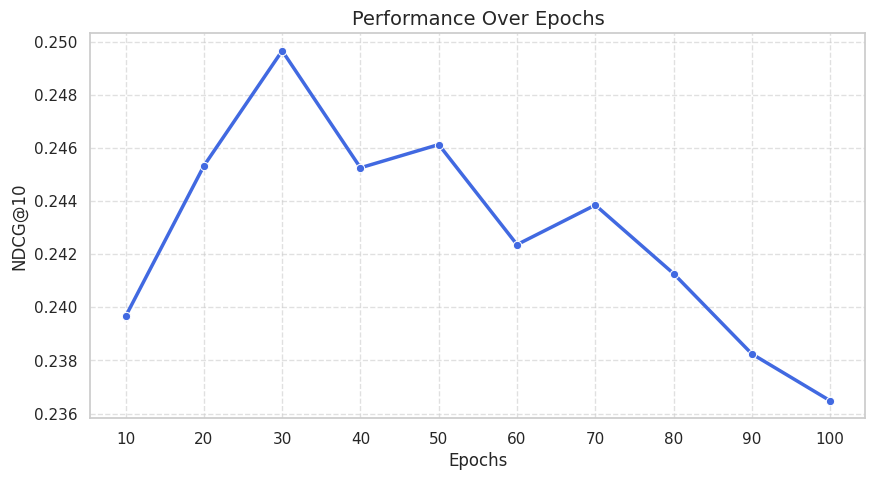

In [51]:
sns.set(style="whitegrid")

# Plot 1: Performance vs. Epochs
plt.figure(figsize=(10, 5))
sns.lineplot(data=epoch_df, x="epoch", y="ndcg", marker="o", linewidth=2.5, color="royalblue")
plt.title("Performance Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("NDCG@10", fontsize=12)
plt.xticks(epoch_df["epoch"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

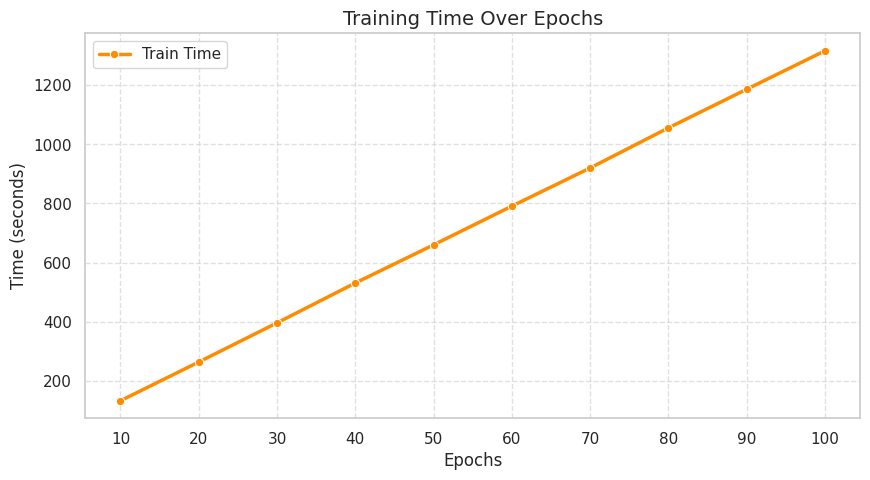

In [52]:
# Plot 2: Train Time & Prediction Time vs. Epochs
plt.figure(figsize=(10, 5))
sns.lineplot(data=epoch_df, x="epoch", y="train_time", marker="o", linewidth=2.5, label="Train Time", color="darkorange")
plt.title("Training Time Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Time (seconds)", fontsize=12)
plt.xticks(epoch_df["epoch"])
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()